# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import joblib
import os

from imblearn.over_sampling import ADASYN

from src.ML_functions import get_param_dist_for_model, evaluate_model, plot_roc_curves

from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Import Datasets

df_train = pd.read_csv('Data_for_Modelling/df_train.csv', sep=',')

df_test = pd.read_csv('Data_for_Modelling/df_test.csv', sep=',')

print(f"Train set shape:{df_train.shape}")
print(f"Test set shape:{df_test.shape}")

Train set shape:(377042, 12)
Test set shape:(127037, 11)


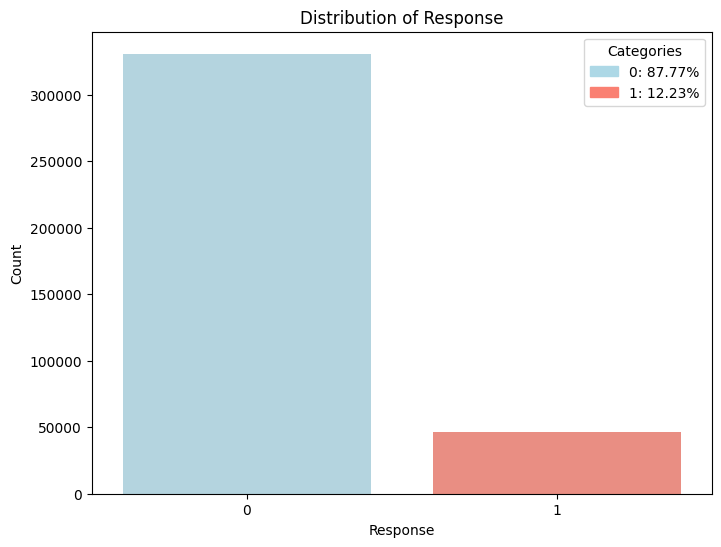

In [3]:
# How target column is distributed (IMBALANCED DATASET)

target_column = 'Response'

value_counts = df_train[target_column].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

colors = ['lightblue', 'salmon']

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette=colors, dodge=False, legend=False)
plt.xlabel(target_column)
plt.ylabel('Count')
plt.title(f'Distribution of {target_column}')
plt.xticks(rotation=0)

handles = [
    mpatches.Patch(color=colors[i], label=f'{index}: {percentages[i]:.2f}%')
    for i, index in enumerate(value_counts.index)
]
plt.legend(handles=handles, title='Categories', loc='upper right')

plt.show()

# TRAINING SET SPLIT AND MODELS DEFINITION

In [4]:
# Split df_train 

X = df_train.drop('Response', axis=1)
y = df_train['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Models definition

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

# MODELS EVALUATION WITH IMBALANCED DATASET

In [7]:
# RandomizedSearchCV 

models_dir = 'Models'
os.makedirs(models_dir, exist_ok=True)

best_models = {}

for name, model in models.items():
    
    print(f"Evaluating {name}...")

    search = RandomizedSearchCV(model, get_param_dist_for_model(name), cv=5, scoring='f1', n_iter=10, n_jobs = -1, verbose=1)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    print(f"Best model parameters for {name}:")
    print(model)
    print(f"Mean F1 score for {name}: {search.best_score_:.4f}")

    joblib.dump(search.best_estimator_, f'{models_dir}/{name}.joblib')

Evaluating Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
# Models evaluation on training and test sets

results_train = {}
results_test = {}

for name, model in best_models.items():
    results_train[name] = evaluate_model(model, X_train, y_train)
    results_test[name] = evaluate_model(model, X_test, y_test)

# Creazione di DataFrame per confrontare i risultati
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

train_metrics_df = pd.DataFrame.from_dict(results_train, orient='index', columns=metrics)
test_metrics_df = pd.DataFrame.from_dict(results_test, orient='index', columns=metrics)

# Concatenazione dei DataFrame
comparison_df = pd.concat([train_metrics_df, test_metrics_df], keys=['Train', 'Test'], axis=0)

# Visualizzazione dei risultati
print(comparison_df)

In [ ]:
# ROC curve and AUC:

plot_roc_curves(results_train, set_type='train')
plot_roc_curves(results_test, set_type='test')

# MODELS EVALUATION USING ADASYN for RESAMPLING

In [5]:
# Oversampling with ADASYN

adasyn = ADASYN(random_state=42)

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print(f"X Train set shape:{X_train_resampled.shape}")
print(f"y Train set shape:{y_train_resampled.shape}")

X Train set shape:(598584, 11)
y Train set shape:(598584,)


In [ ]:
# RandomizedSearchCV using resampled training set

models_dir = 'Models'
os.makedirs(models_dir, exist_ok=True)

best_models = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    
    print(f"Evaluating {name}...")

    search = RandomizedSearchCV(model, get_param_dist_for_model(name), cv=skf, n_iter=10, verbose=1)
    search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = search.best_estimator_

    name_mod = name + '_with_ADASYN'

    joblib.dump(search.best_estimator_, f'{models_dir}/{name_mod}.joblib')

In [ ]:
# Models evaluation on training and test sets

results_train = {}
results_test = {}

for name, model in best_models.items():
    results_train[name] = evaluate_model(model, X_train_resampled, y_train_resampled)
    results_test[name] = evaluate_model(model, X_test, y_test)

# Creazione di DataFrame per confrontare i risultati
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

train_metrics_df = pd.DataFrame.from_dict(results_train, orient='index', columns=metrics)
test_metrics_df = pd.DataFrame.from_dict(results_test, orient='index', columns=metrics)

# Concatenazione dei DataFrame
comparison_df = pd.concat([train_metrics_df, test_metrics_df], keys=['Train', 'Test'], axis=0)

# Visualizzazione dei risultati
print(comparison_df)

In [ ]:
# ROC curve and AUC:

plot_roc_curves(results_train, set_type='train')
plot_roc_curves(results_test, set_type='test')